In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

templist = [5, 10, 15, 20, 25, 30, 35, 40]
#templist = [-9.4, -4.4, 0.4, 5.3, 10.3, 15.3, 20, 25, 30, 35, 40]
badchannels = [18, 29, 37, 38, 44, 58]
runlist = [
#           [1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595],
#           [1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582],
#           [1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569],
           [1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556],    
           [1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542],  
           [1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525],
           [1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1493],
           [1433, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442],
           [1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451],
           [1457, 1458, 1459, 1460, 1461 ,1462, 1463, 1464, 1465],
           [1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506]   
          ]
        
        
bias = np.array([
#                 [51.6, 52.1, 52.6, 53.1, 53.6, 54.1, 54.6, 55.1, 55.6],
#                 [51.9, 52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9],
#                 [52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2],
                 [52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9, 56.4],
                 [52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7],
                 [53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0],
                 [53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7, 57.2],
                 [53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8],
                 [54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0],
                 [54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8, 58.3]
                ])

In [2]:
def processTemperature(arr, idx):

    df = pd.DataFrame(columns=['chan', 'slope', 'temp', 'intercept', 'r_value', 'p_value', 'std_err', 
                               'Vbd', 'spe_3V_over', 'spe_54V_fix', 'spe_55V_fix', 'spe_60V_fix', 'spe_65V_fix'])

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%templist[idx])

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("SPE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias[idx]
            y=arSPE[:, 0, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d"%(chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)
            spe_3V_over = slope*(ratio + 3)+intercept
#            spe_55V_fix = slope*55+intercept

            new_row = {'chan': chan, 'slope': slope, 'temp': temp, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio, 
                       'spe_3V_over': spe_3V_over, 'spe_54V_fix': slope*54+intercept,
                       'spe_55V_fix': slope*55+intercept, 'spe_60V_fix': slope*60+intercept, 'spe_65V_fix': slope*65+intercept}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept, slope, ratio))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');
    return df

Bad channel: 58


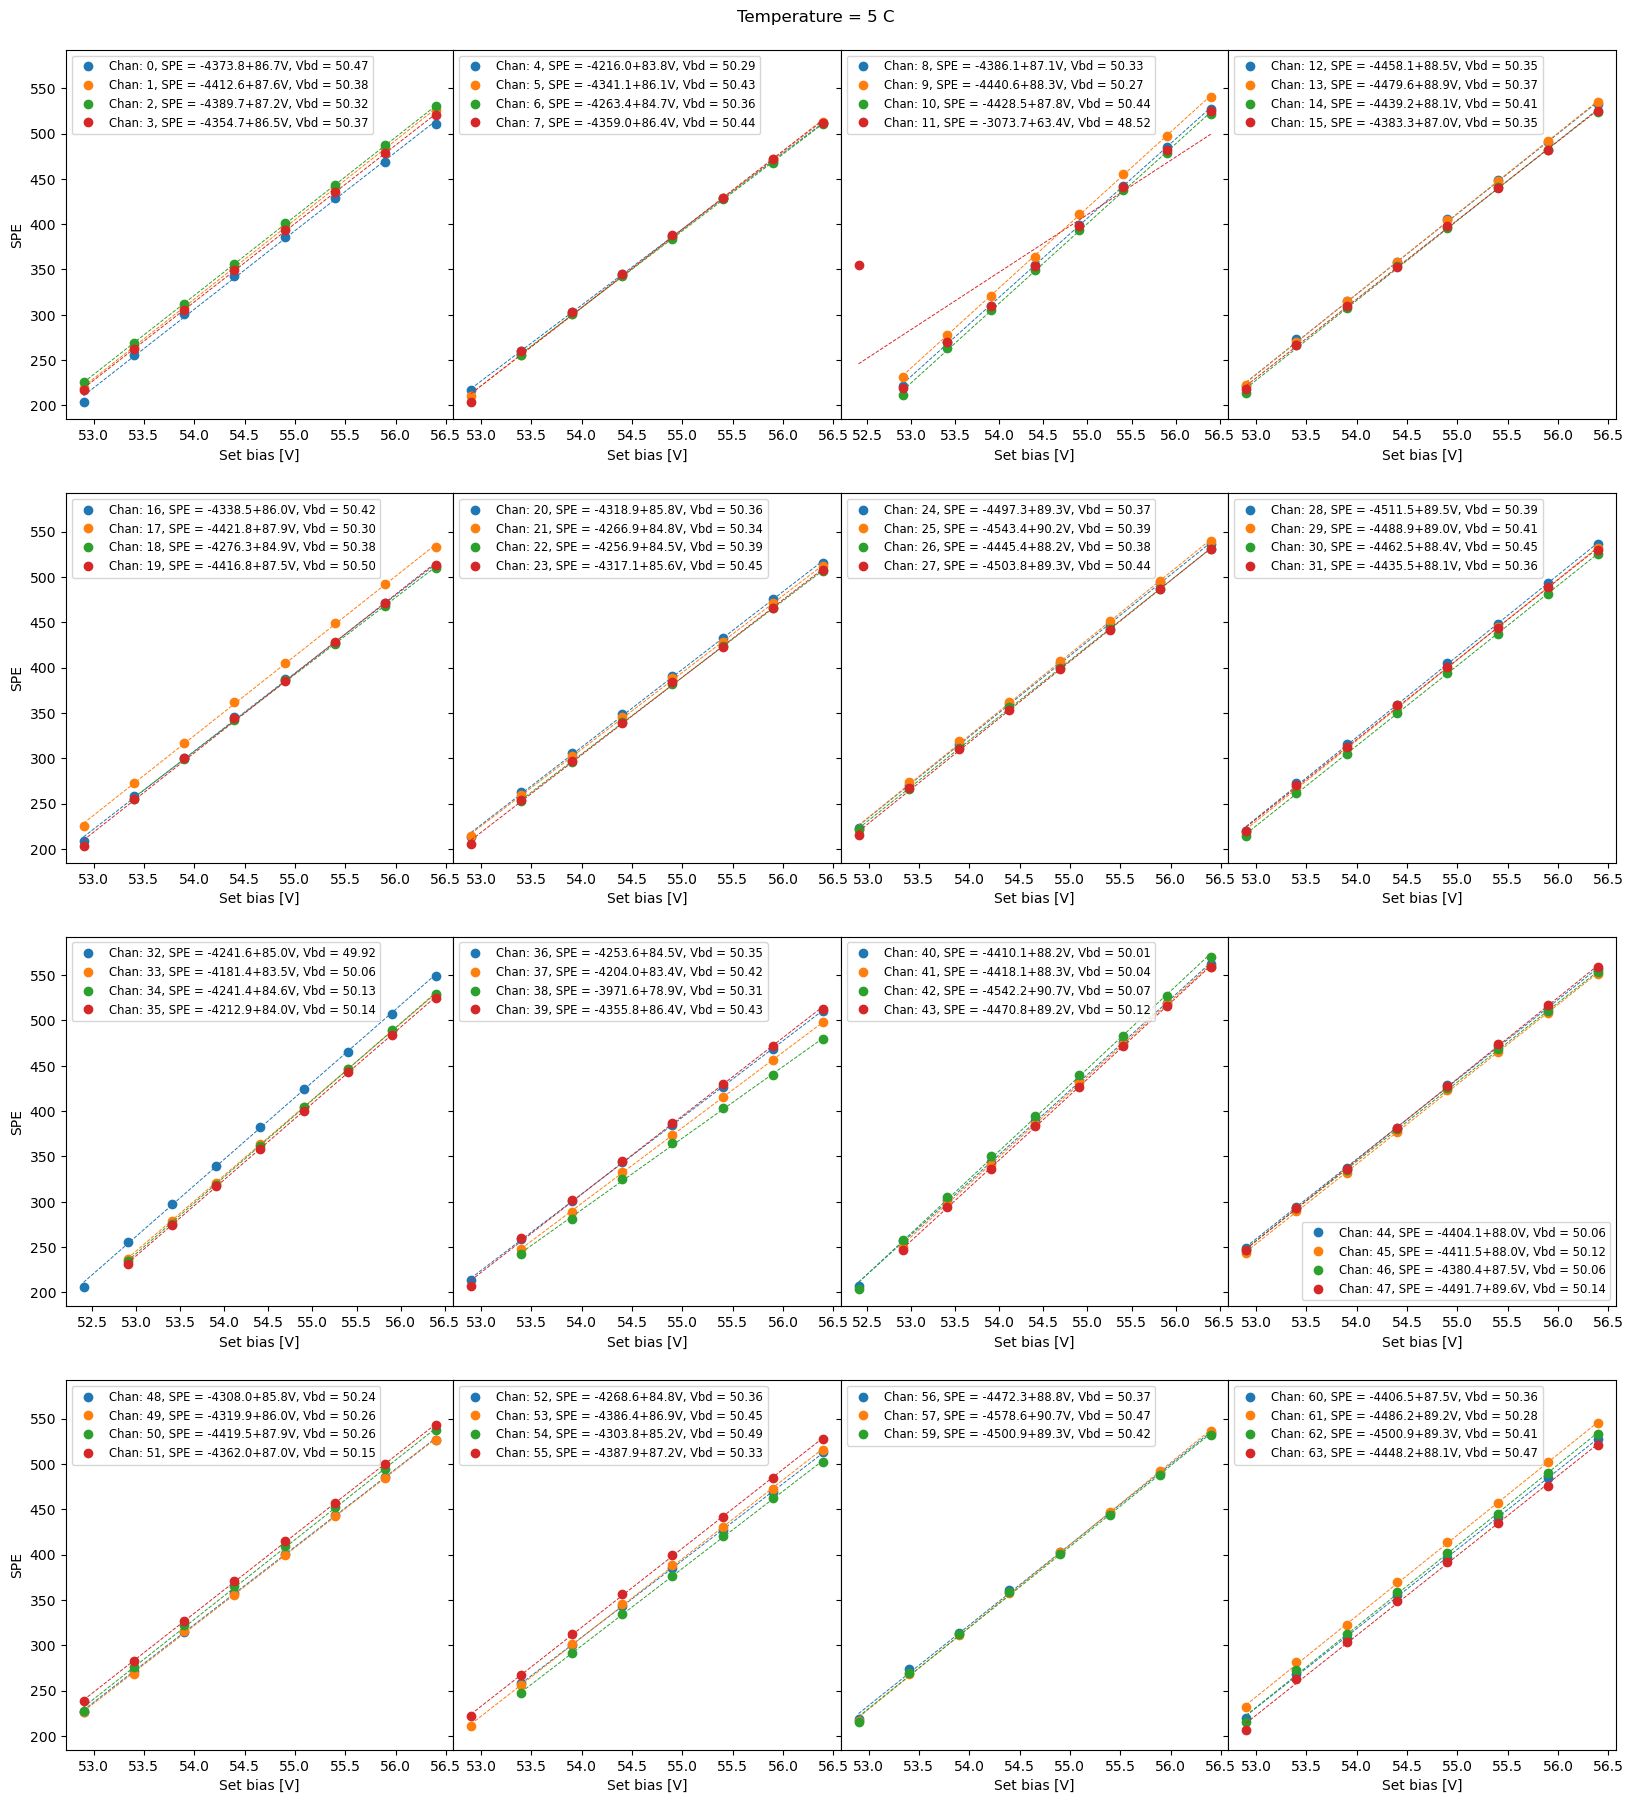

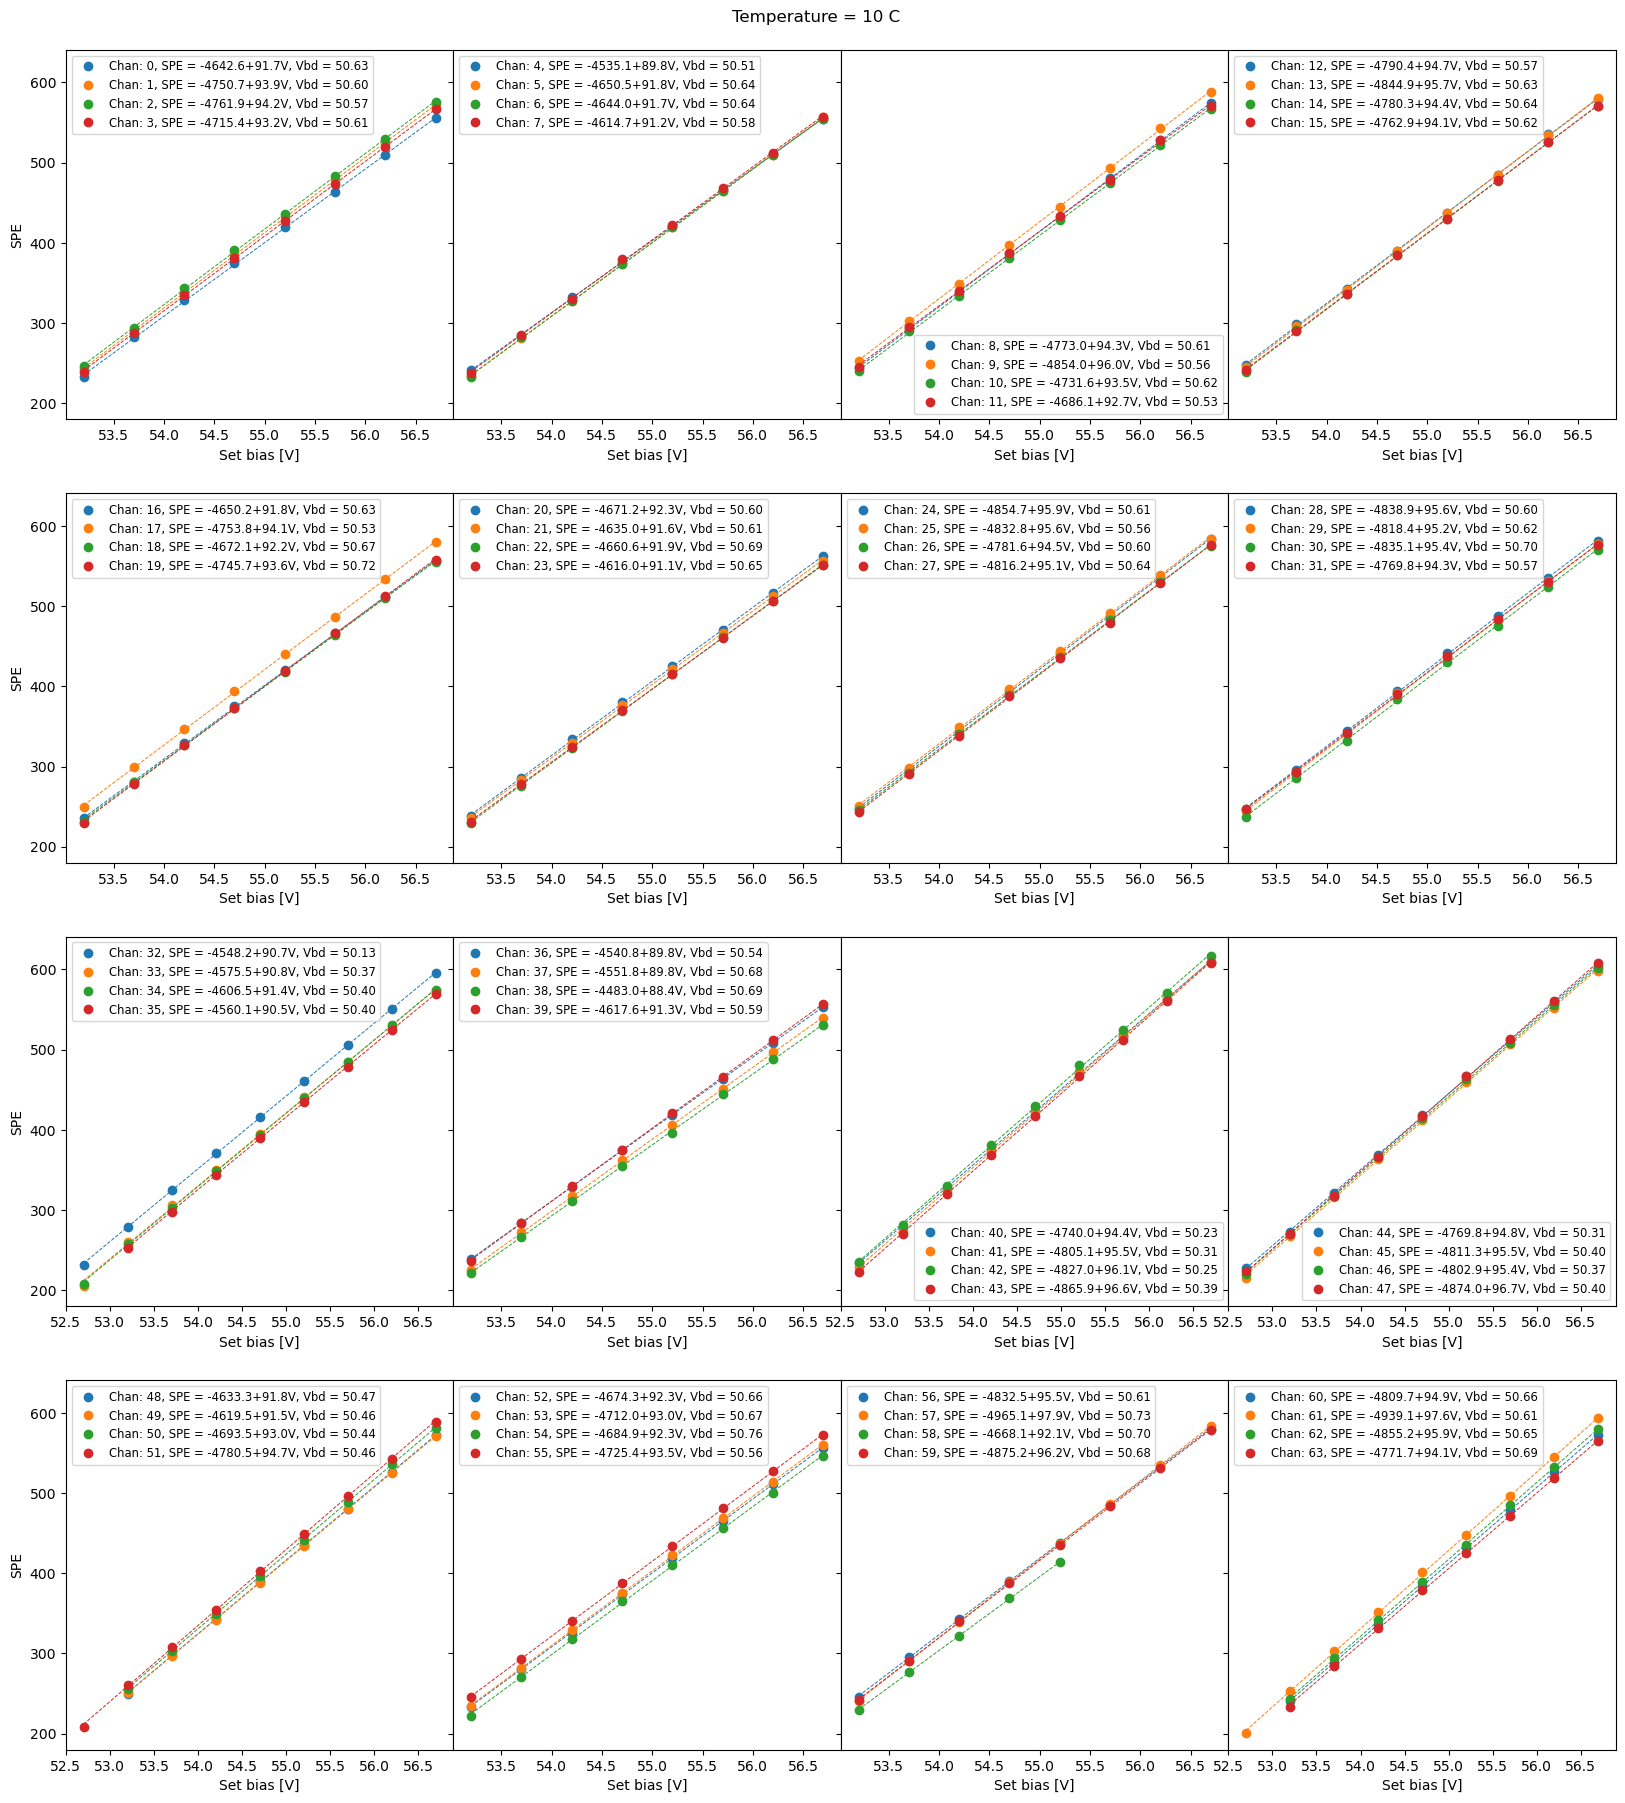

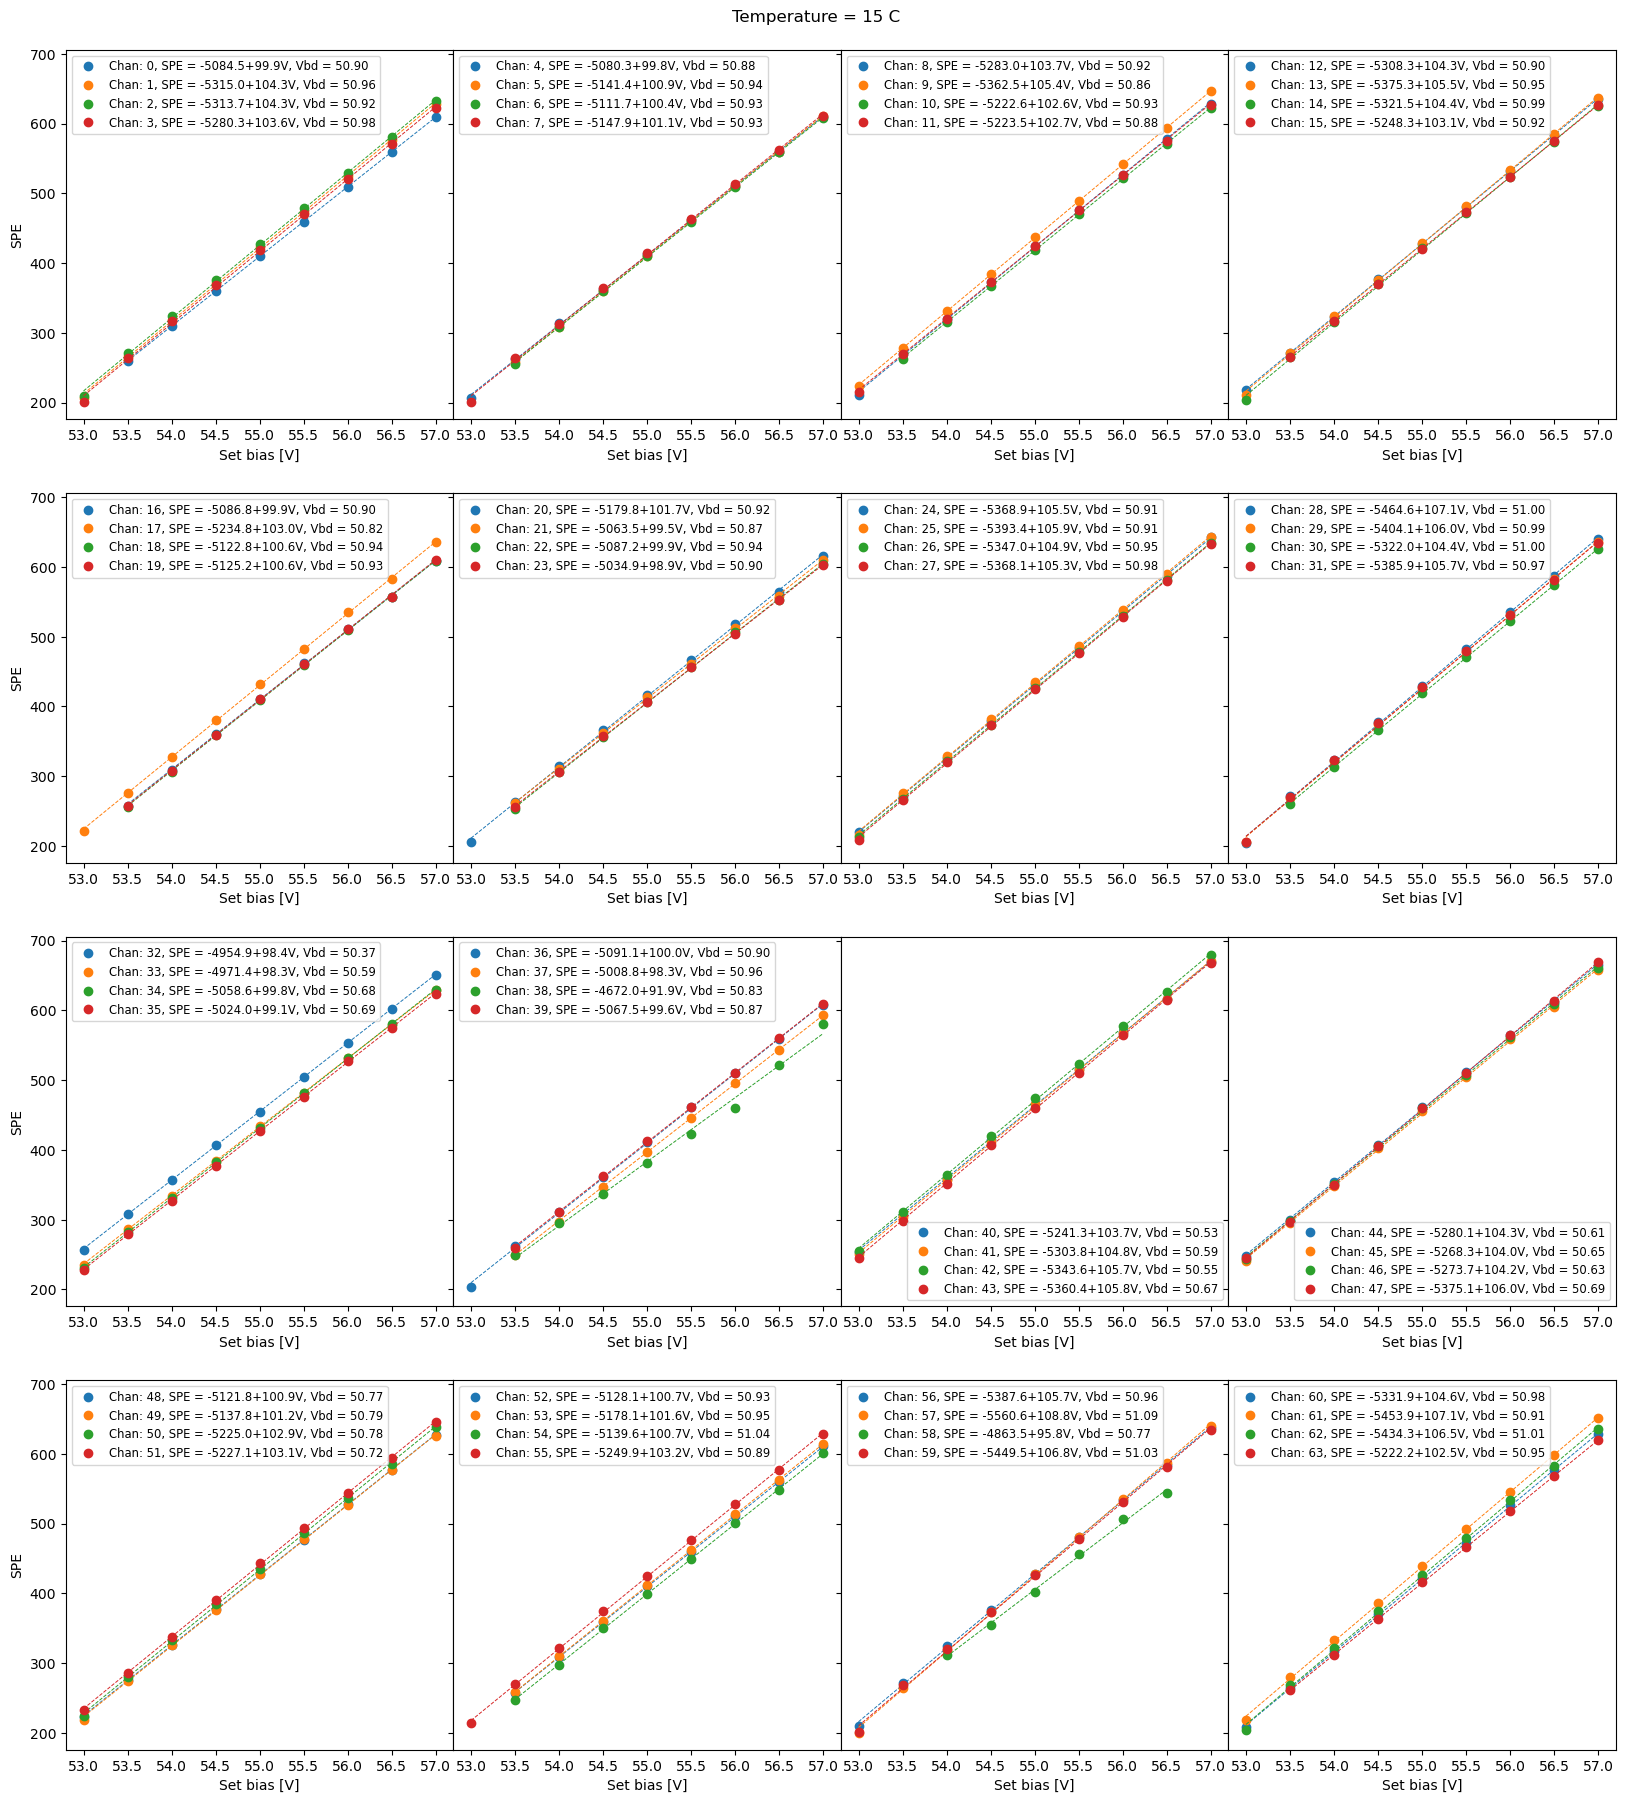

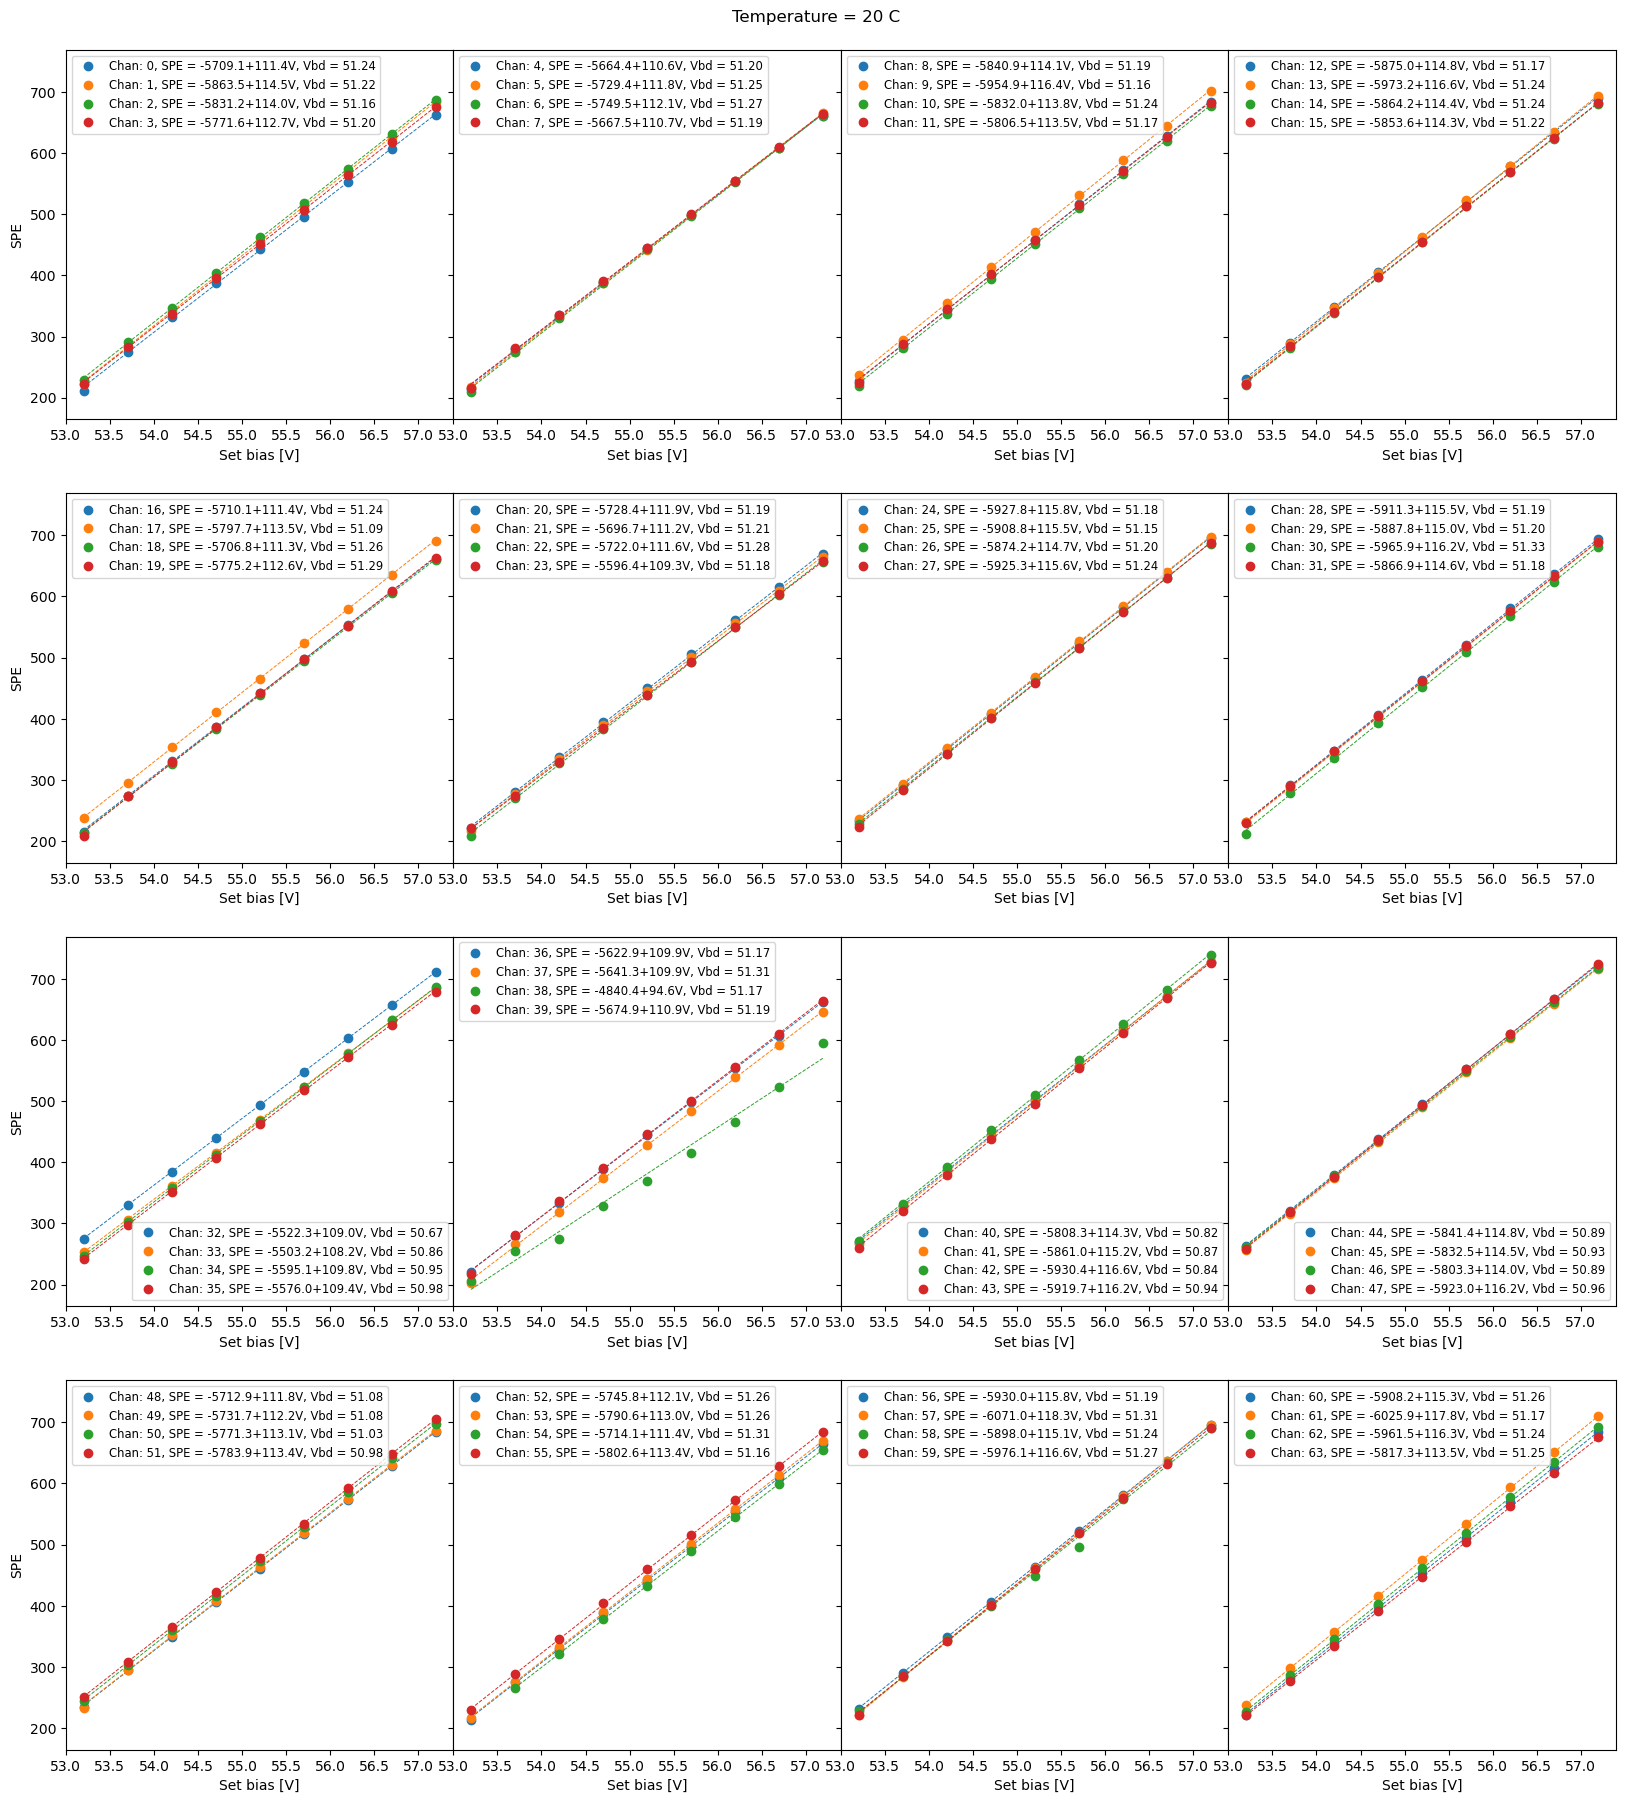

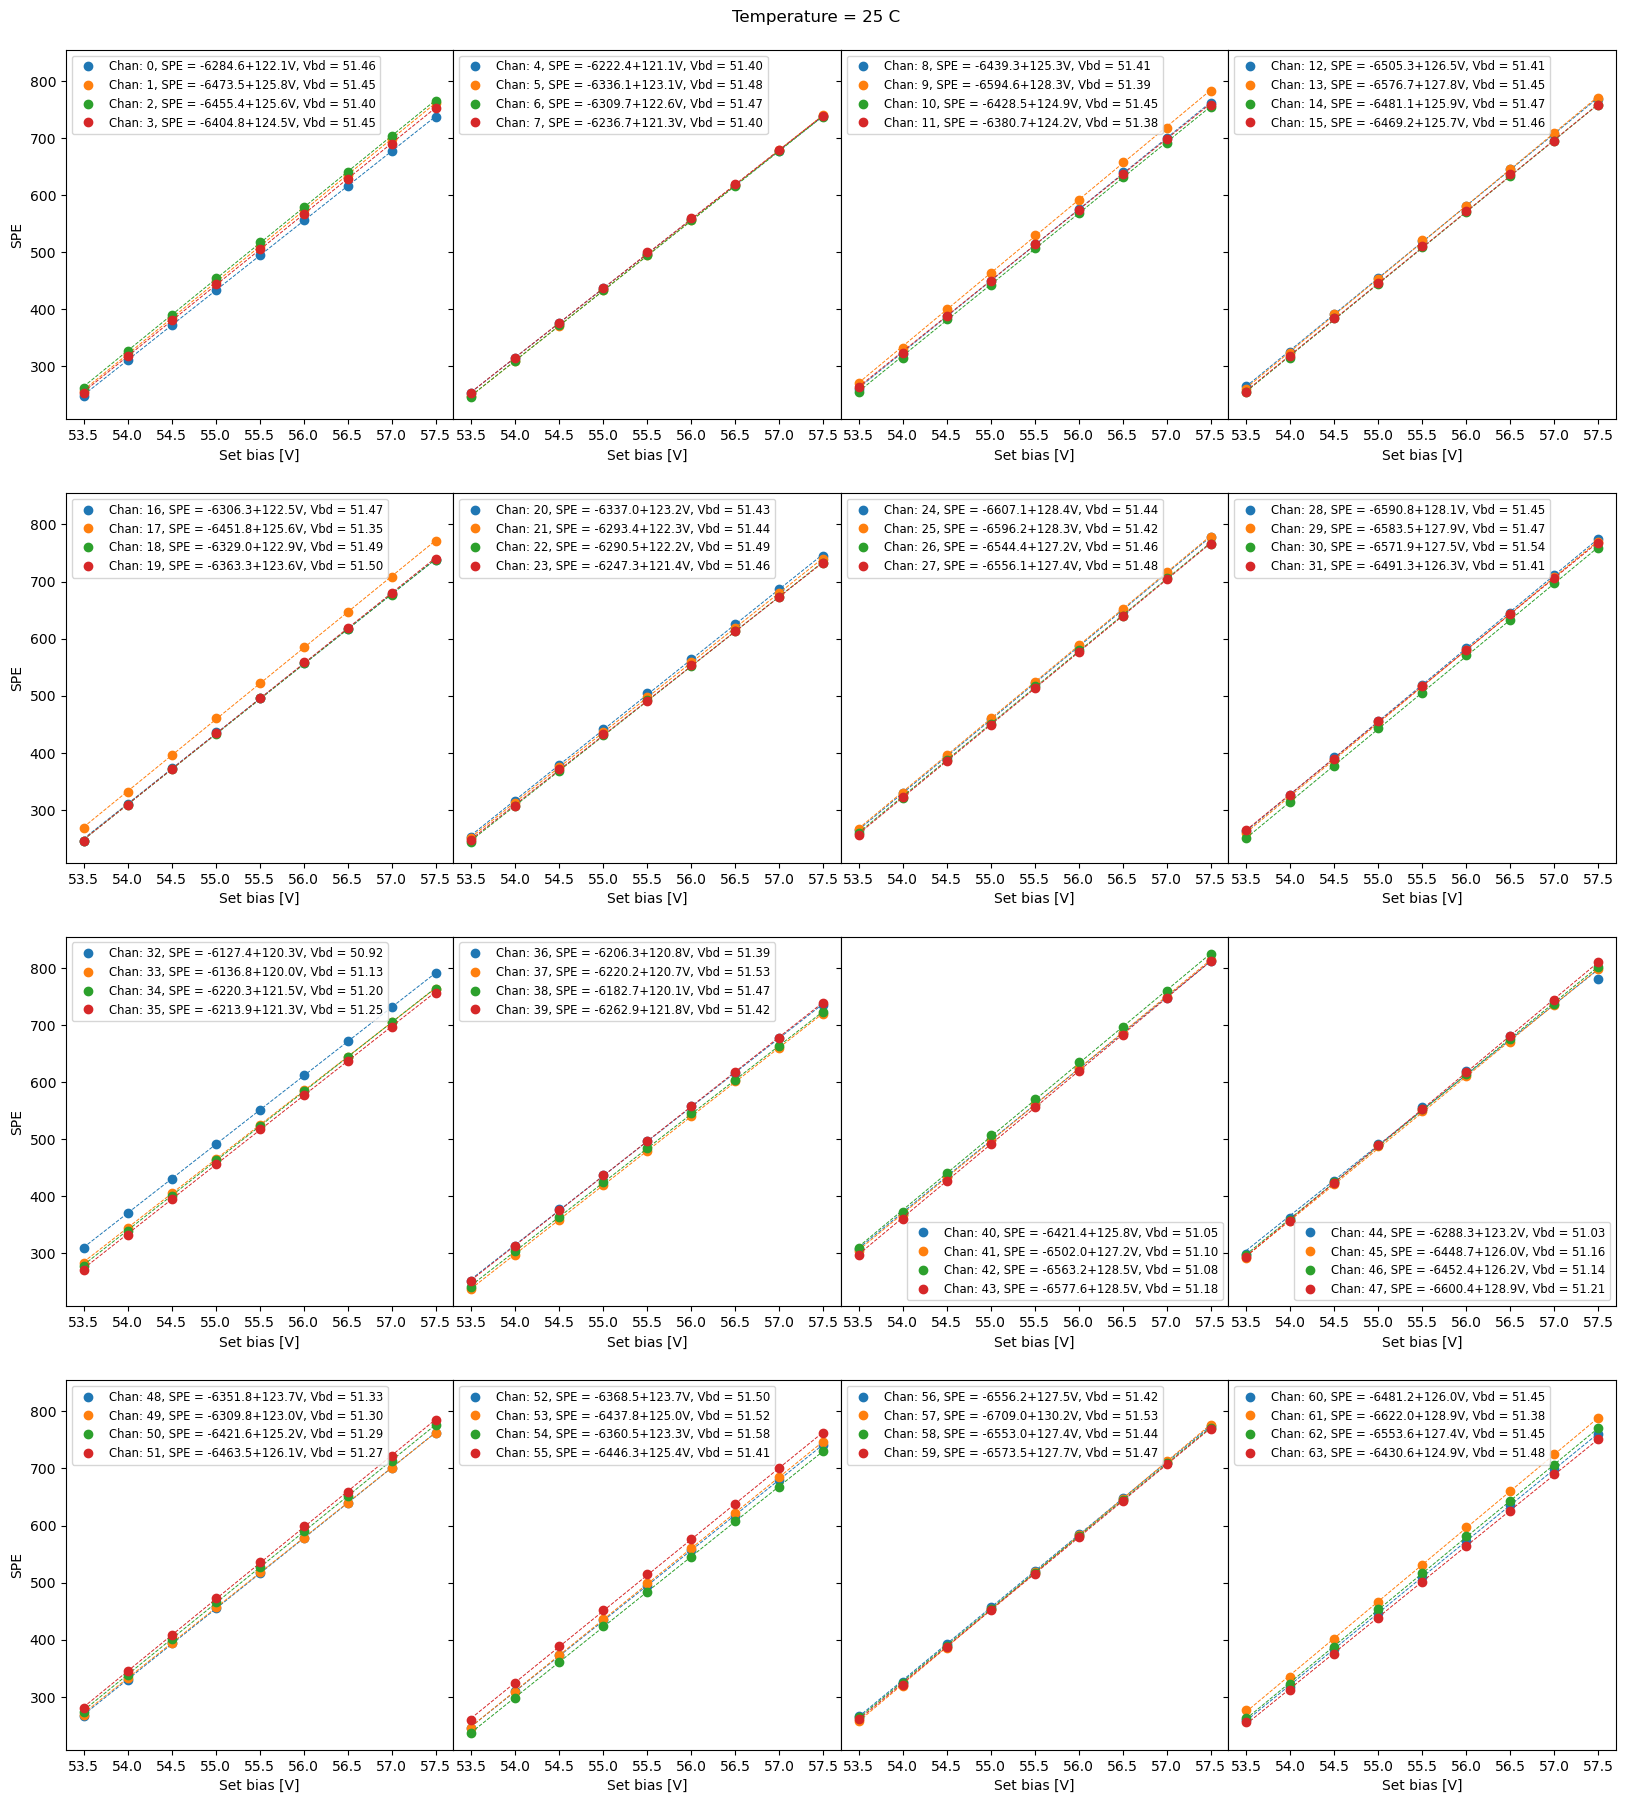

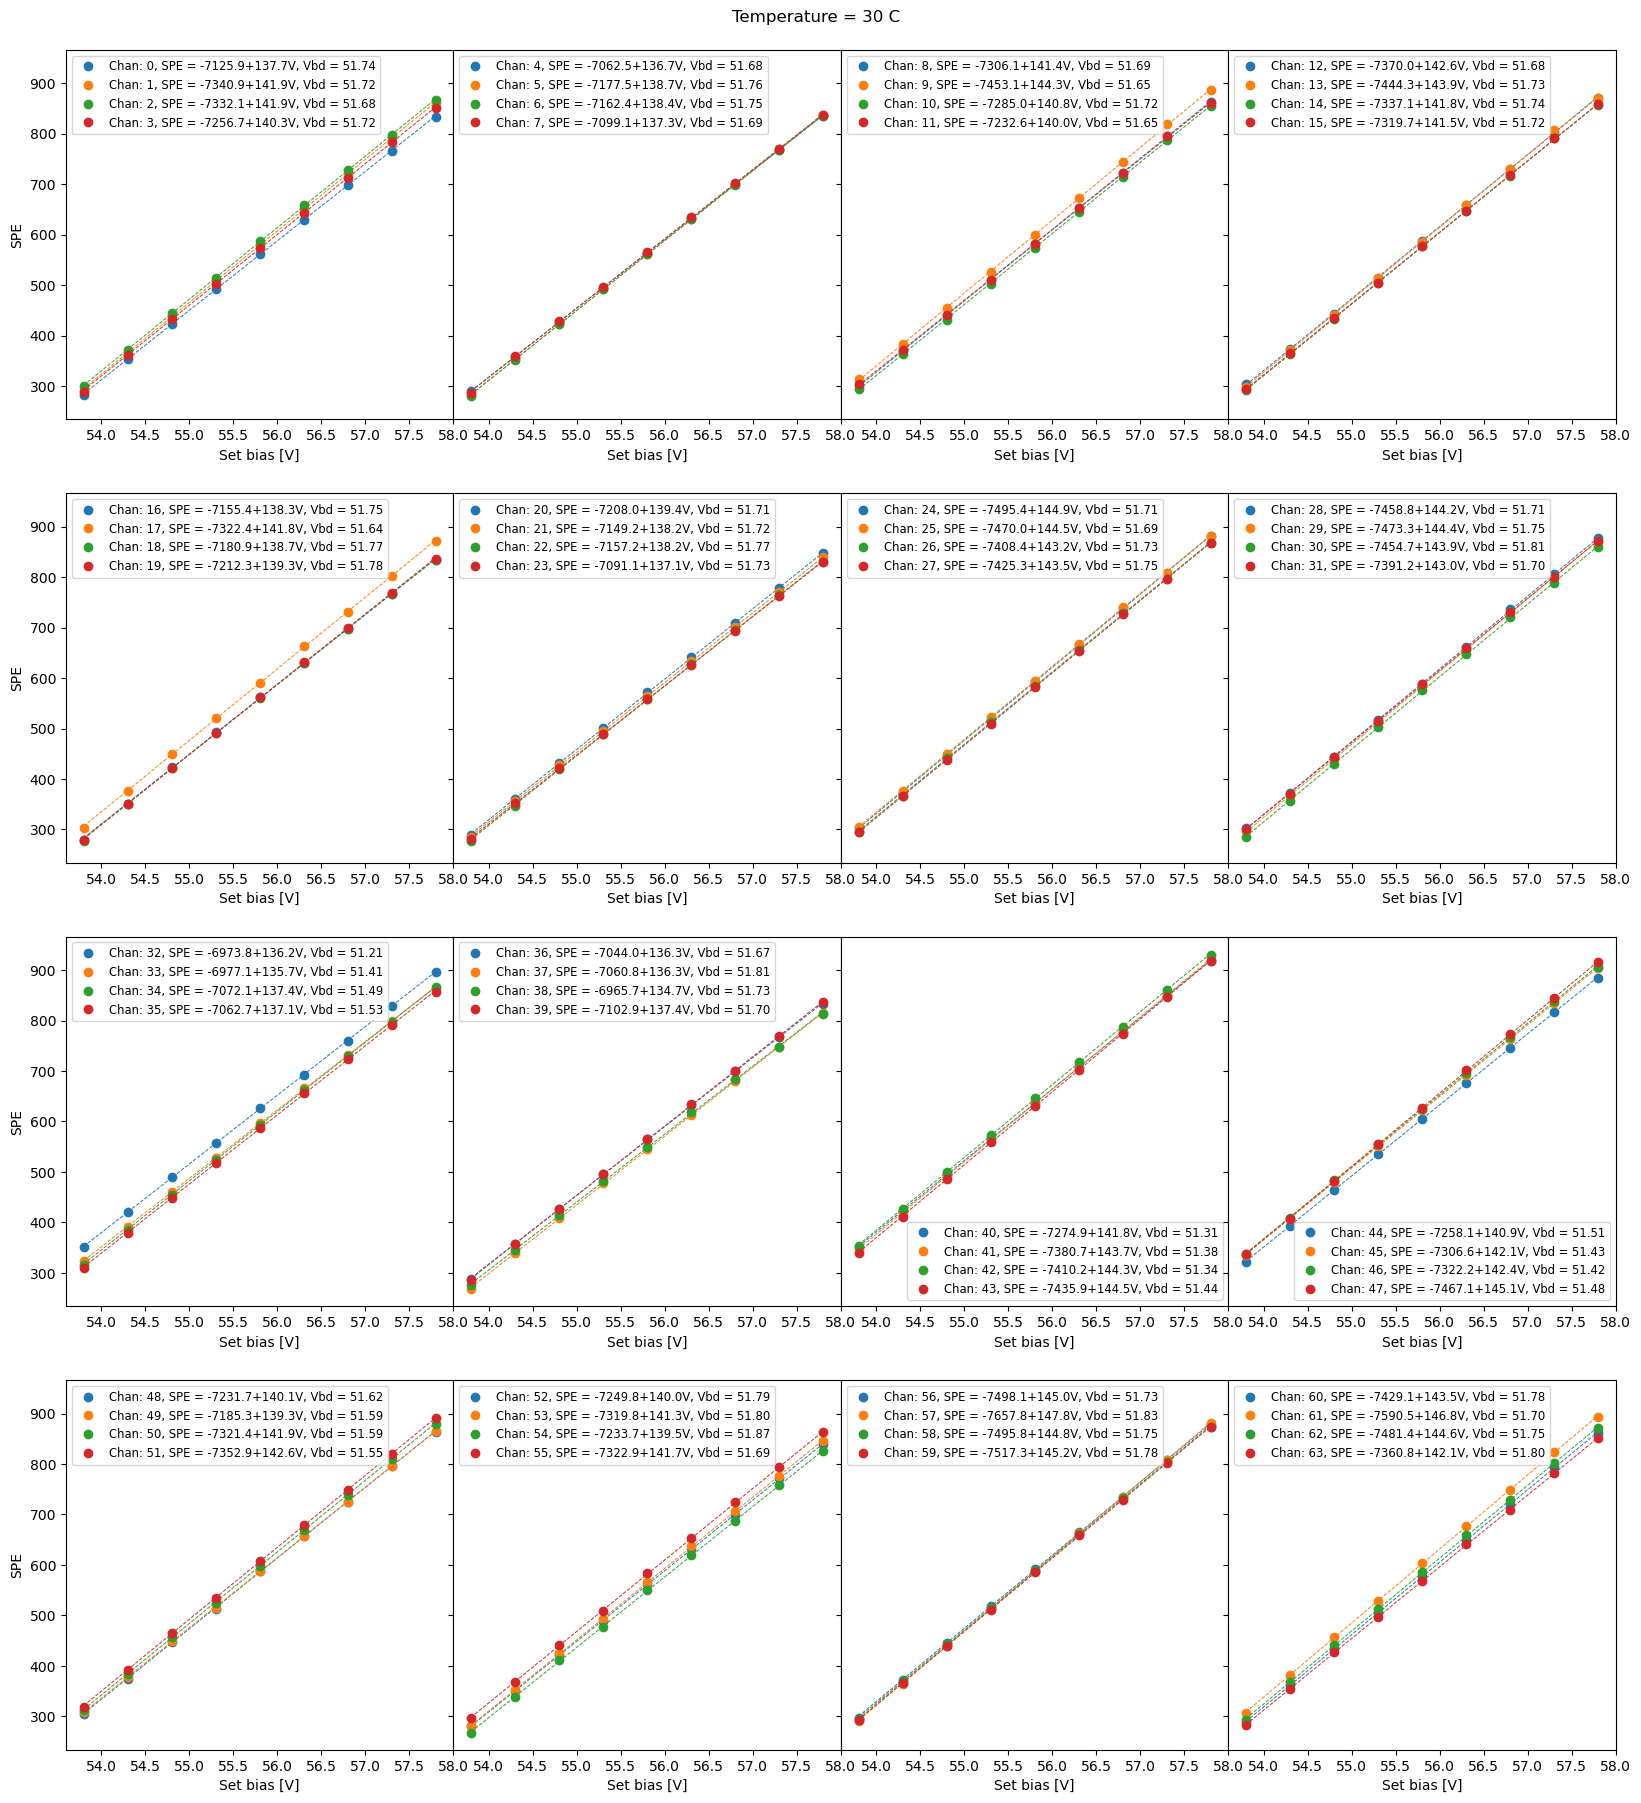

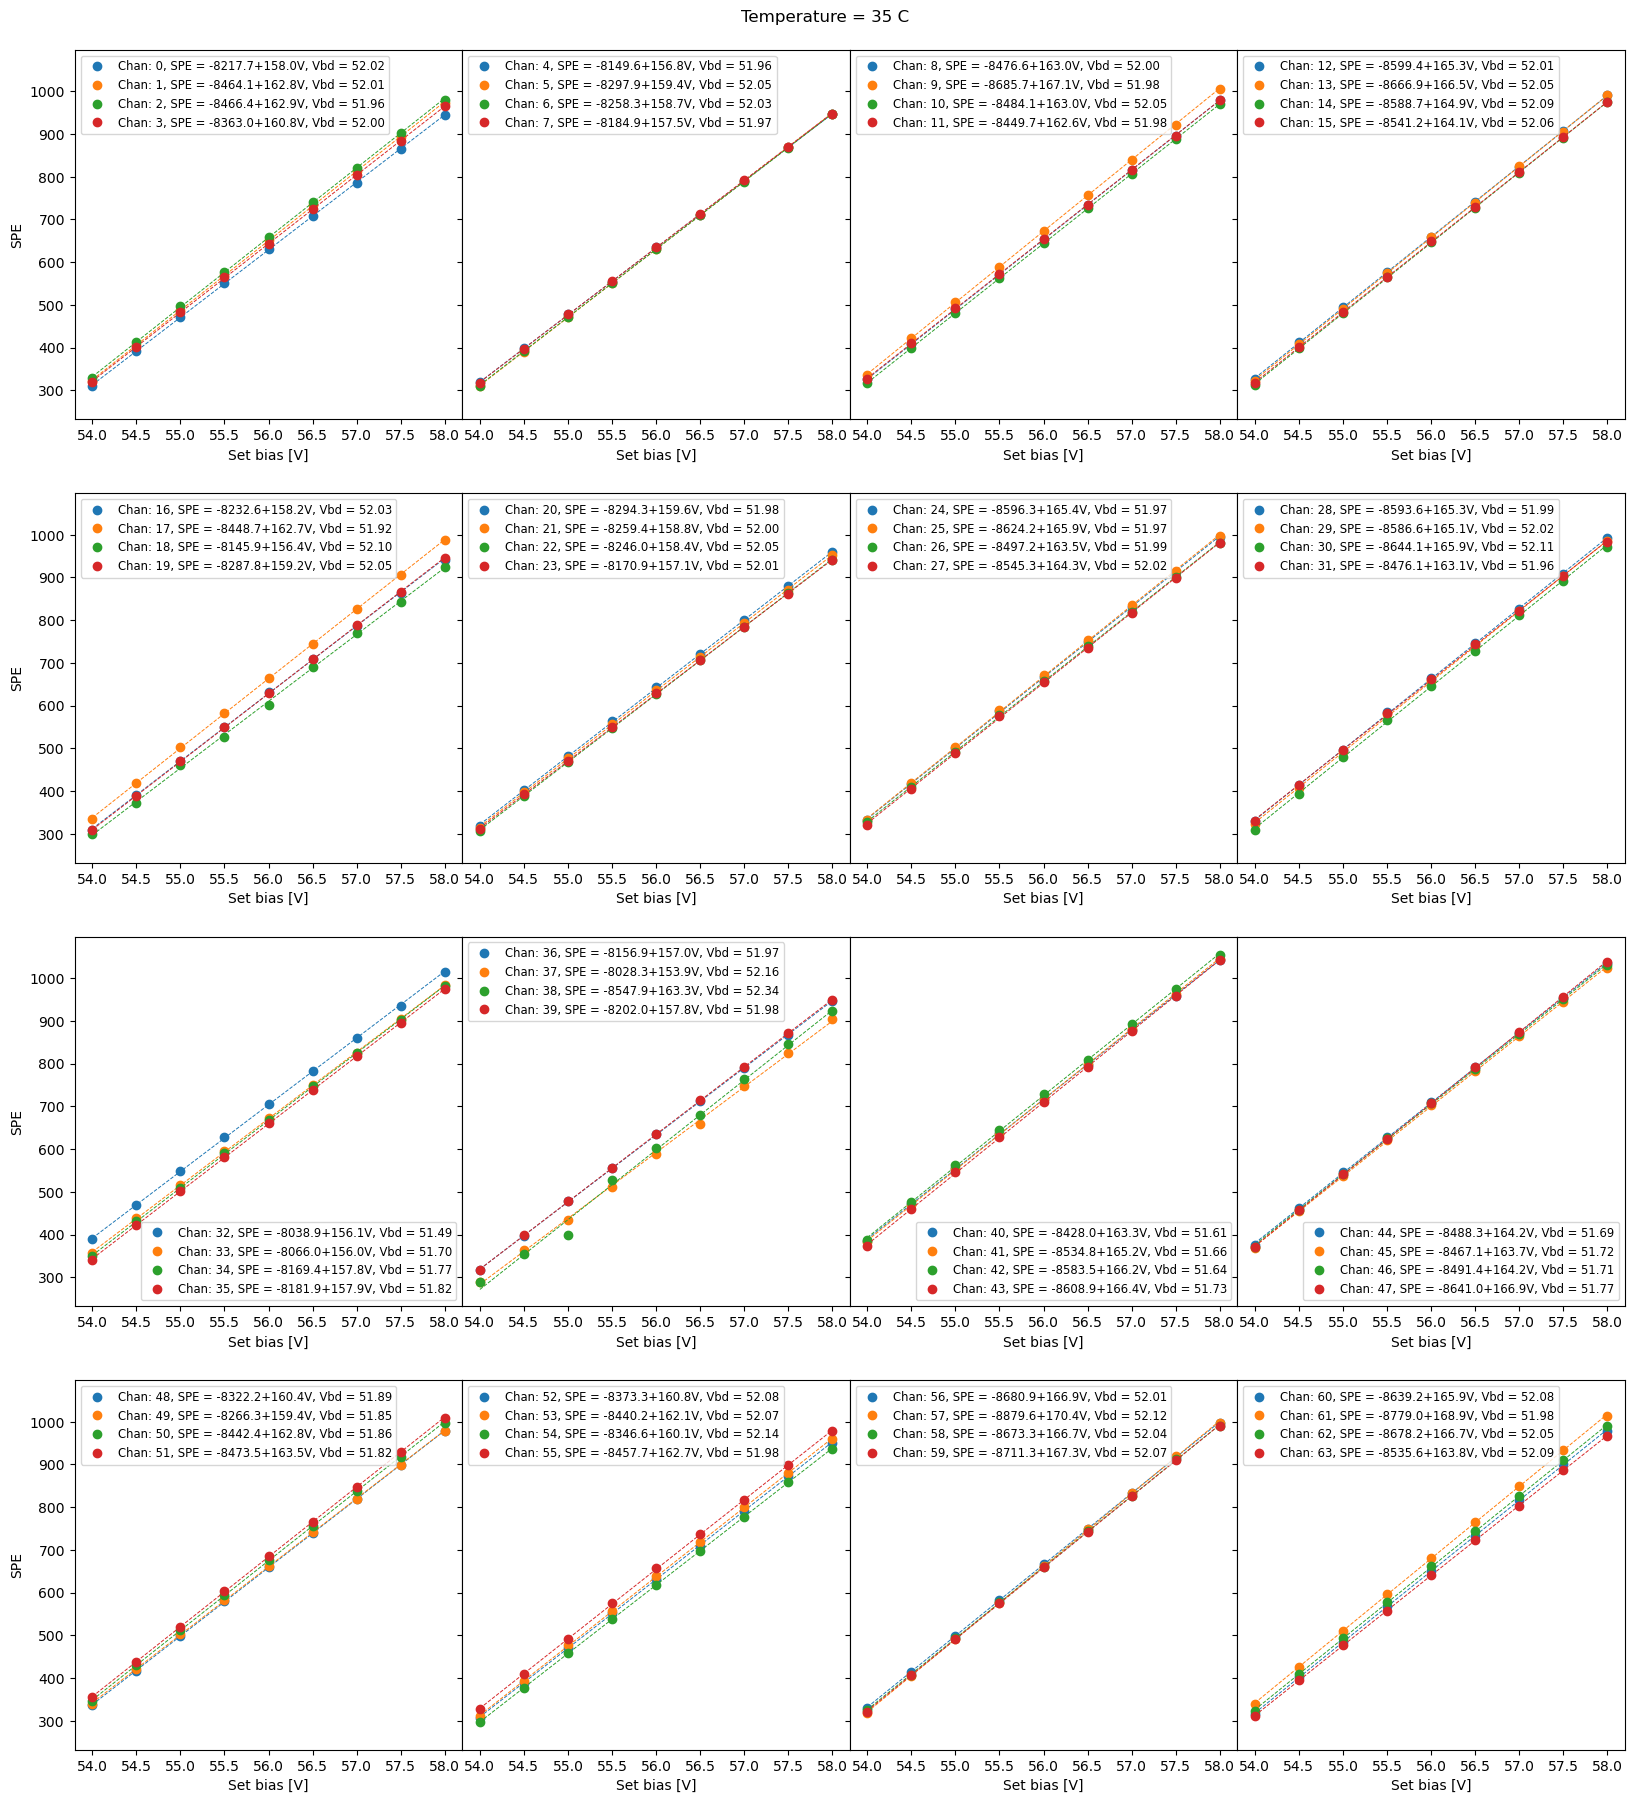

In [3]:
df = pd.DataFrame()

for idx, temp in enumerate(templist):
    processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist[idx], userunlist=True, remove=False)
    arr, arSpills = processor.getData(DATASET) # get akward array for "runSummary" tree
    
    if not np.array_equal(np.array(runlist[idx]), arr['runNumber'].to_numpy()):
        print("Input run list order and data do not match")
    
    #Mask channels which were not calibrated
#    var = 'calibConstants'    
    var = 'calibConstantsTemperatureCorrected'    
    arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()
    
    df_tmp = processTemperature(arSPE, idx)
    df = pd.concat([df, df_tmp], ignore_index=True)

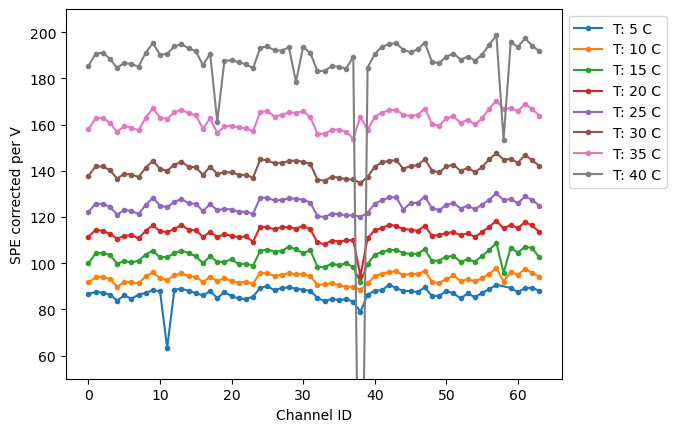

In [4]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['slope'], '.-', label=('T: %d C'%temp))
    plt.xlabel("Channel ID")
    plt.ylabel("SPE corrected per V");
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(50, 210);

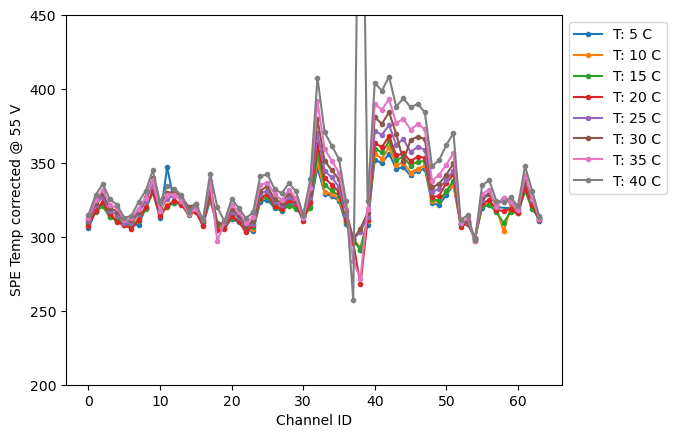

In [5]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['spe_54V_fix'], '.-', label=('T: %d C'%temp))

    plt.xlabel("Channel ID")
    plt.ylabel("SPE Temp corrected @ 55 V");
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(200, 450);

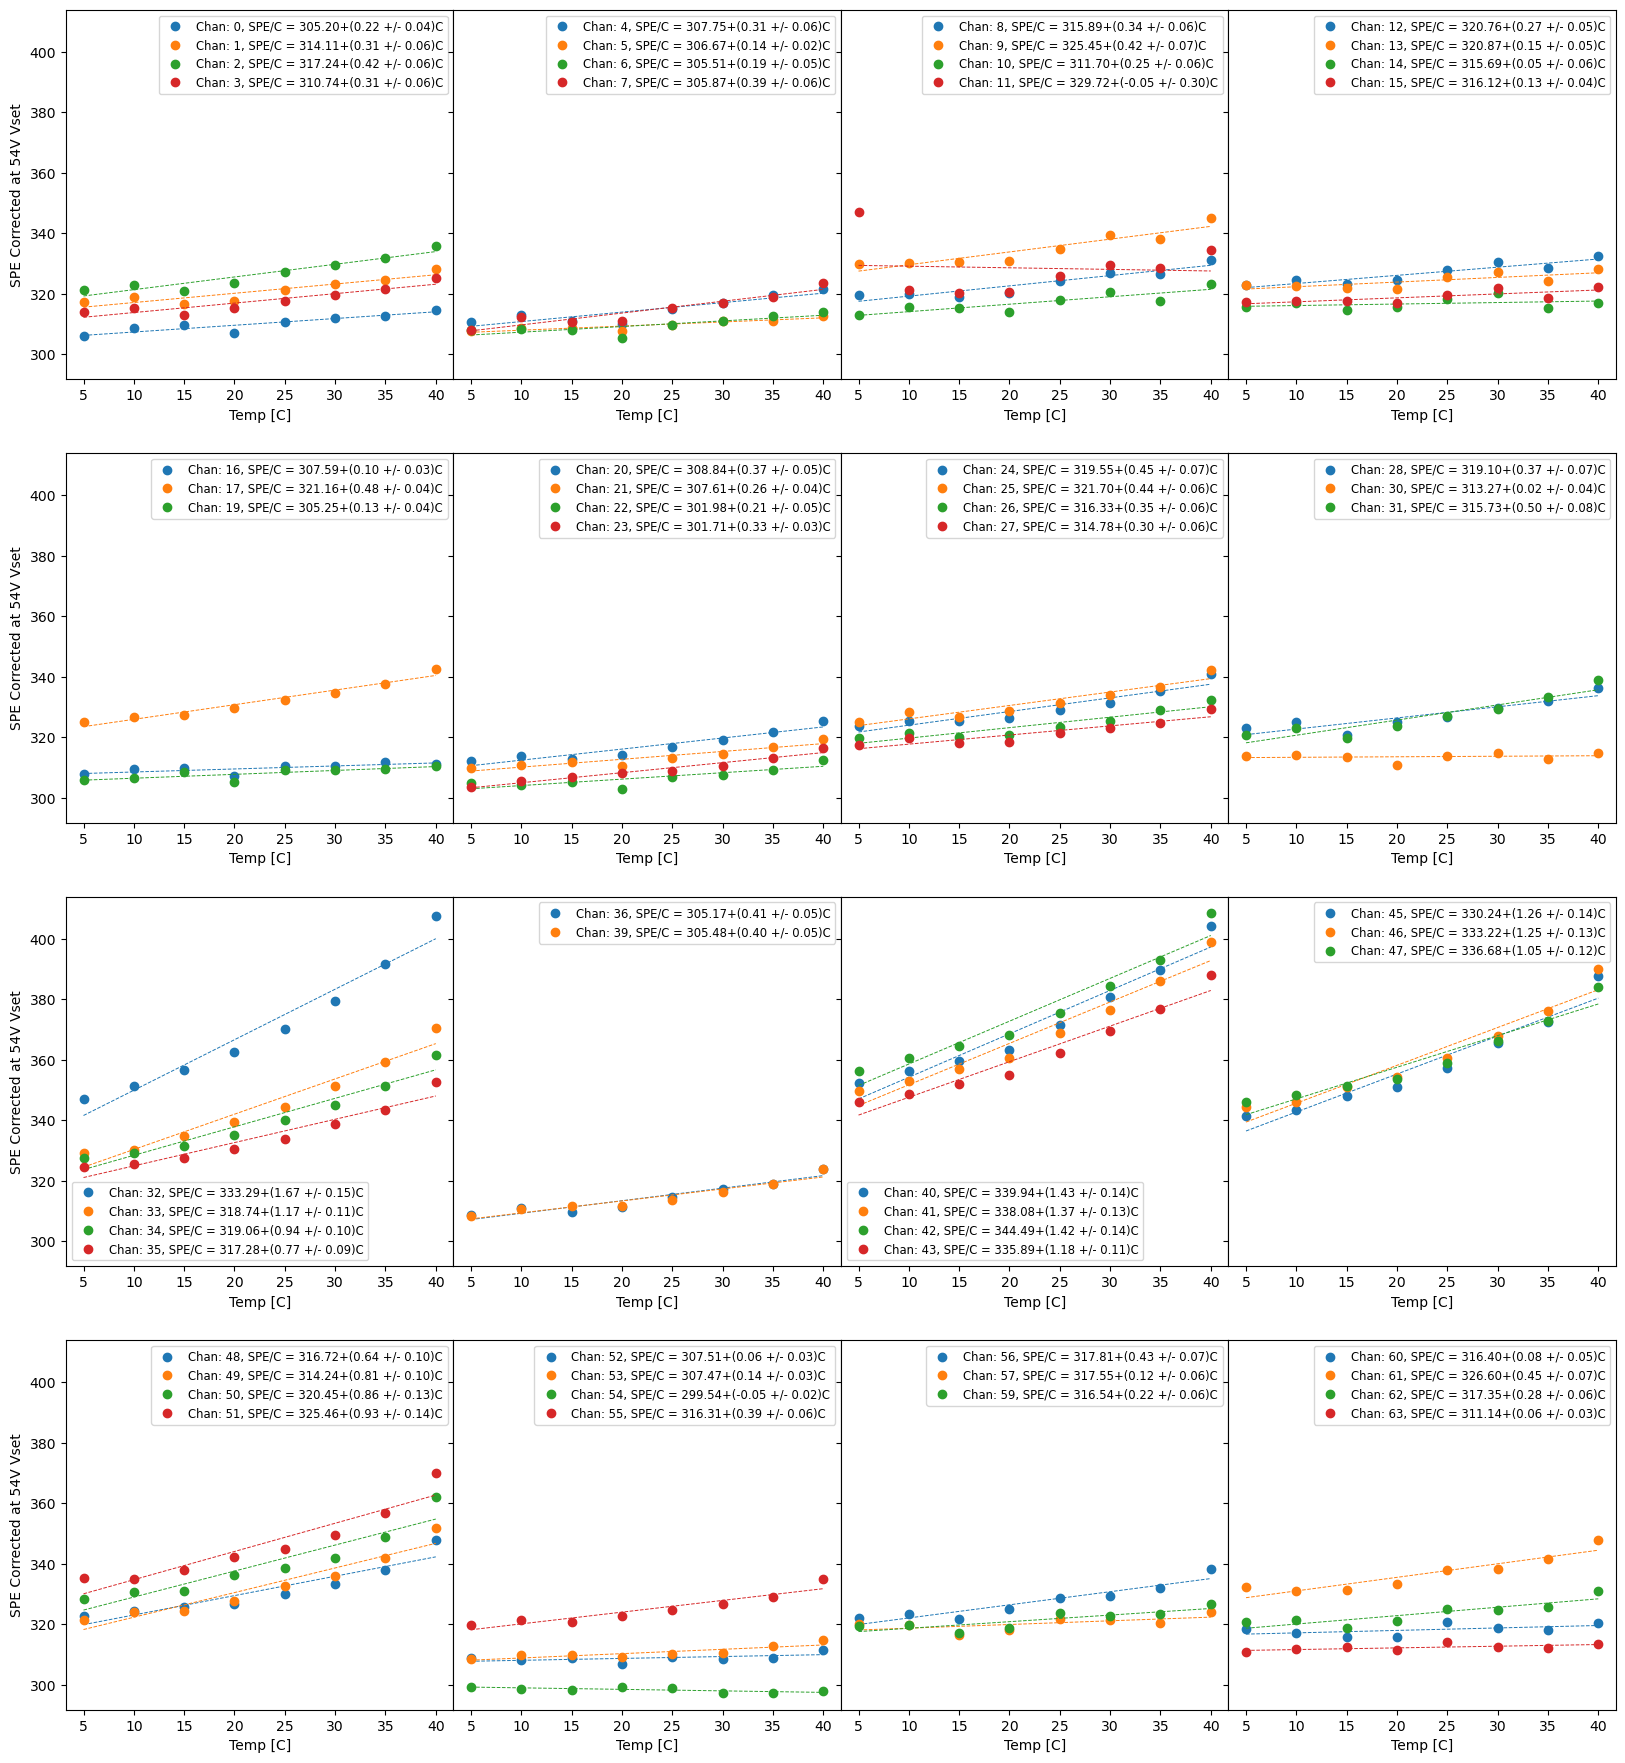

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfSPE_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("SPE Corrected at 54V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in badchannels:
            continue
            
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['spe_54V_fix'].to_numpy()

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, SPE/C = %.2f+(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        dfSPE_Temp.loc[len(dfSPE_Temp)] = new_row

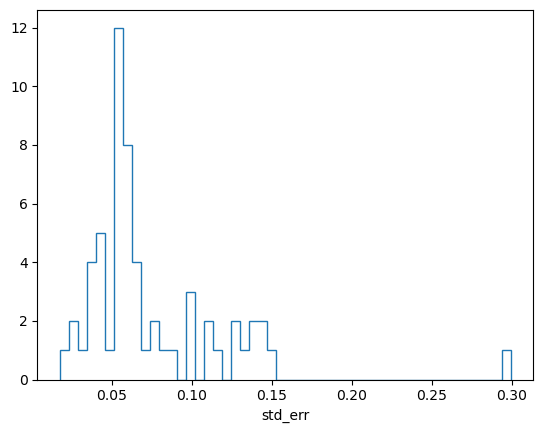

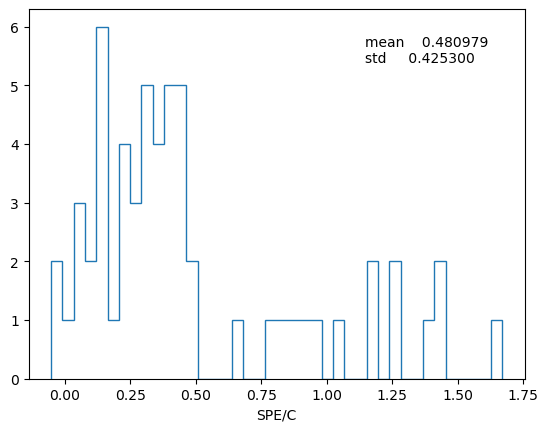

In [7]:
plt.hist(dfSPE_Temp['std_err'], histtype='step', bins=50);
plt.xlabel('std_err')
plt.figure()
plt.hist(dfSPE_Temp.query('std_err<0.5')['slope'], histtype='step', bins=40);
plt.xlabel('SPE/C');
plt.figtext(0.65,0.77, dfSPE_Temp['slope'].describe().loc[['mean','std']].to_string());

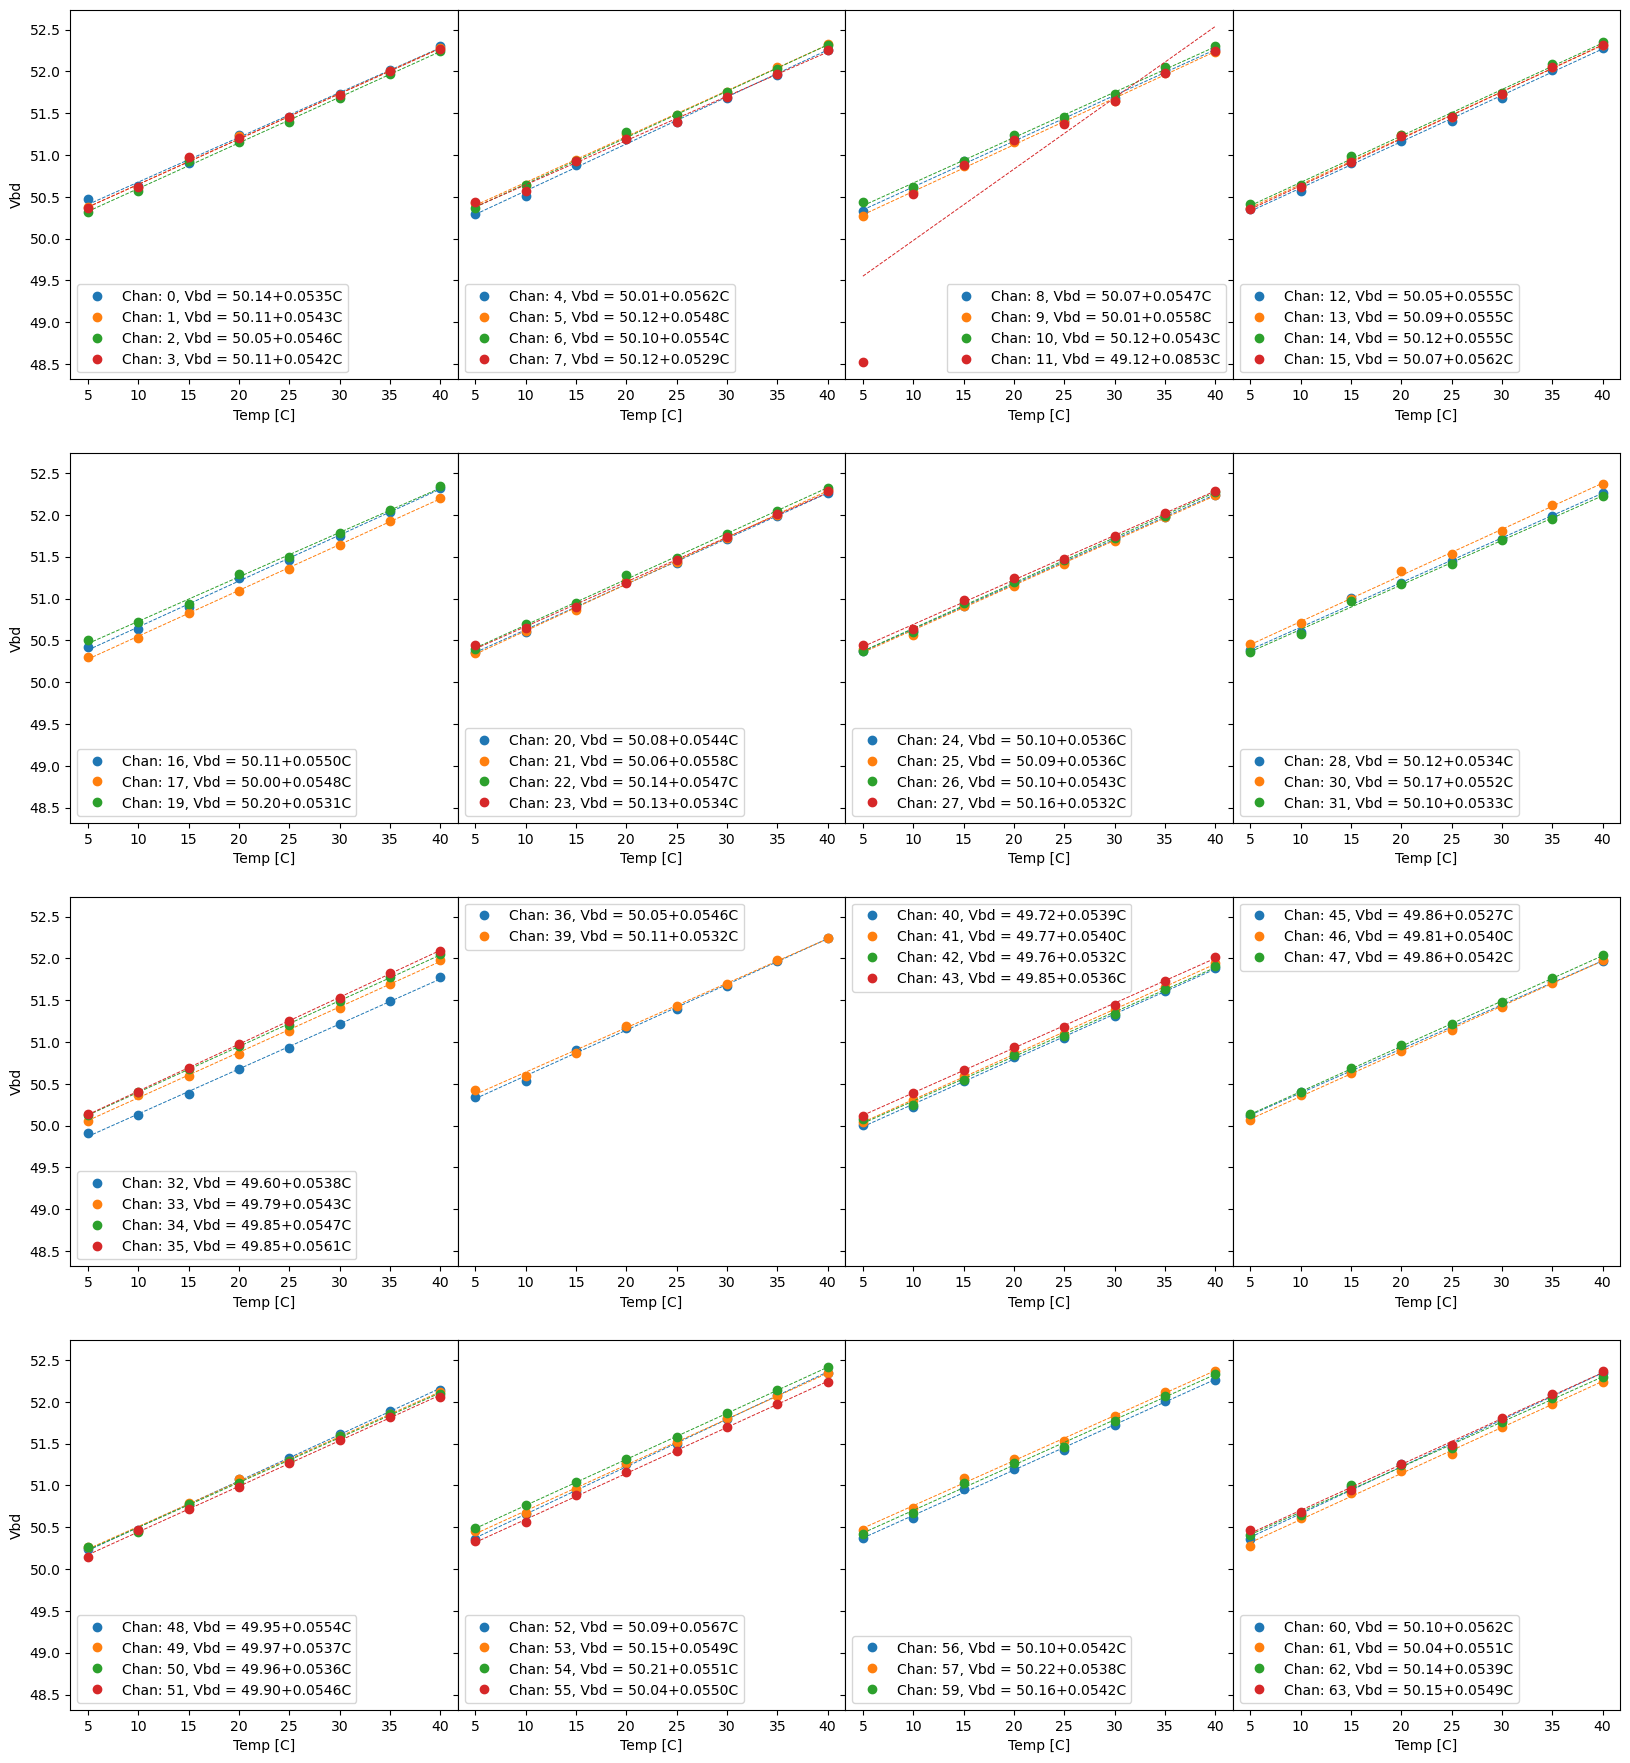

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfVbd = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("Vbd")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        
        if chan in badchannels:
            continue
        
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['Vbd']

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, Vbd = %.2f+%.4fC'%(chan, intercept, slope))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        new_row = {'chan': chan, 'slope': slope*1000, 'intercept': intercept,
           'r_value': r_value, 'p_value': p_value, 'std_err': std_err*1000}
        dfVbd.loc[len(dfVbd)] = new_row
        ax.legend()

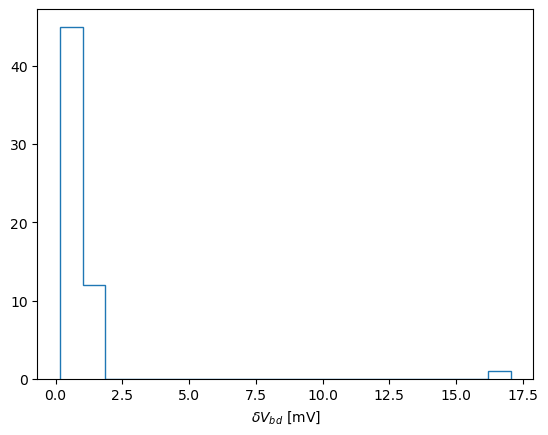

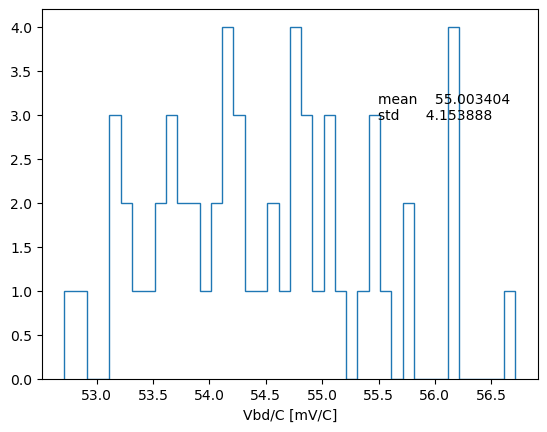

In [9]:
plt.hist(dfVbd['std_err'], histtype='step', bins=20)
plt.xlabel("$\delta V_{bd}$ [mV]")
plt.figure()

var = dfVbd.query('std_err<5')['slope']
plt.hist(var, histtype='step', bins=40);
plt.xlabel("Vbd/C [mV/C]")
plt.figtext(0.65,0.65, dfVbd['slope'].describe().loc[['mean','std']].to_string());

(49.0, 53.0)

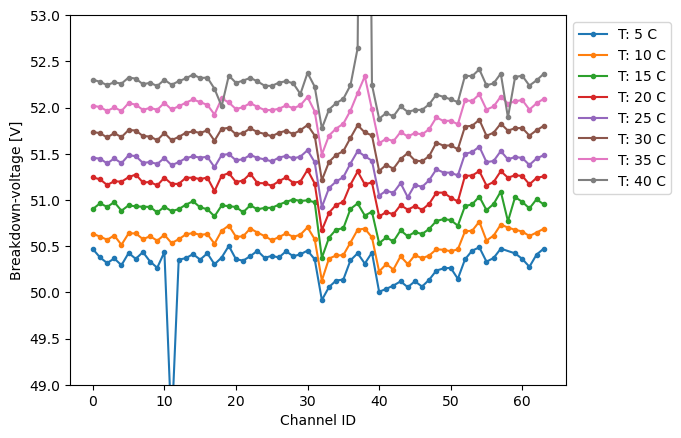

In [10]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['Vbd'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("Breakdown-voltage [V]");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(49, 53)

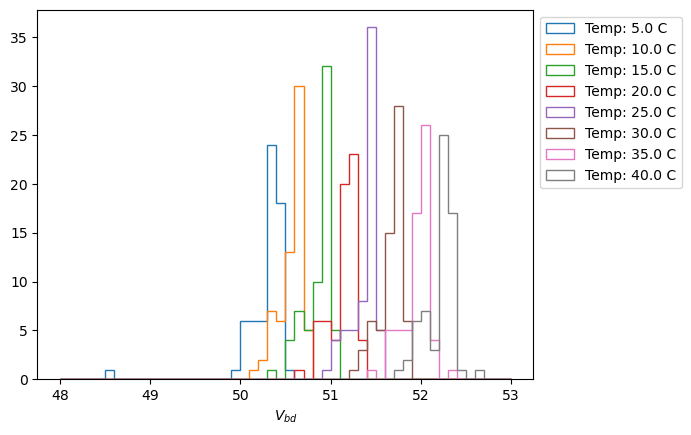

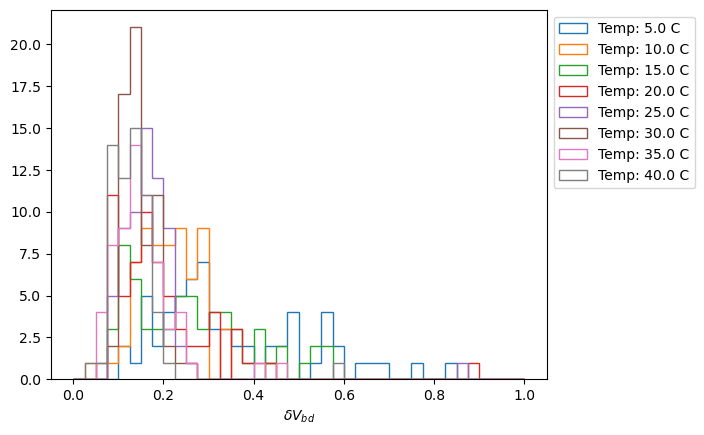

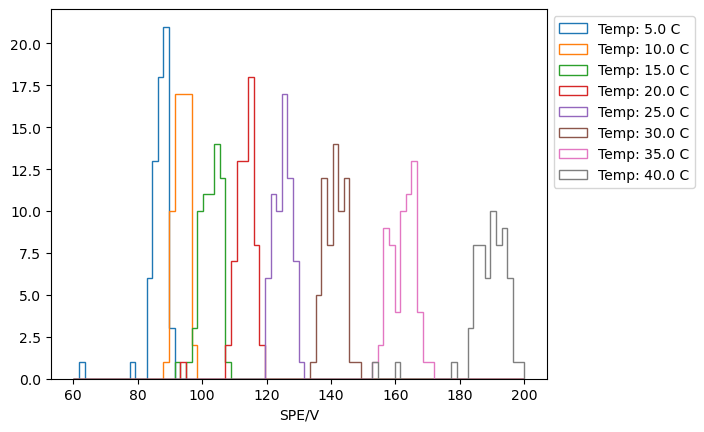

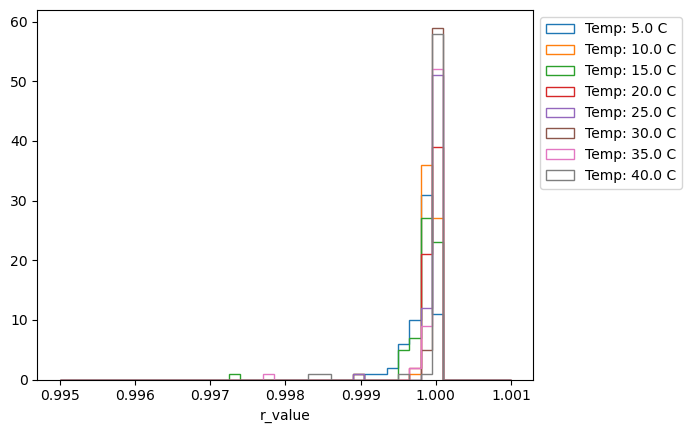

In [11]:
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['Vbd'], bins=50, range=(48, 53), histtype='step', label='Temp: %.1f C'%temp);
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('$V_{bd}$');
    
plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['std_err'], bins=40, range=(0, 1), histtype='step', label='Temp: %.1f C'%temp);
    plt.xlabel('std_err');
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))    
    plt.xlabel('$\delta V_{bd}$')

plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['slope'], bins=80, range=(60, 200), histtype='step', label='Temp: %.1f C'%temp);
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('SPE/V');

plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %f'%temp)['r_value'], bins=40, range=(0.995, 1.001), histtype='step', label='Temp: %.1f C'%temp);
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('r_value');

In [12]:
pd.set_option('display.max_rows', None)
df

chan       slope  temp     intercept   r_value       p_value    std_err  \
0       0   86.664140     5  -4373.842786  0.999444  4.304333e-10   0.687600   
1       1   87.590449     5  -4412.630955  0.999966  9.465425e-14   0.168549   
2       2   87.240638     5  -4389.689260  0.999986  6.201879e-15   0.106887   
3       3   86.459235     5  -4354.652214  0.999948  3.428140e-13   0.208827   
4       4   83.829239     5  -4216.049155  0.999972  5.740484e-14   0.154809   
5       5   86.089790     5  -4341.136155  0.999891  3.271687e-12   0.304512   
6       6   84.654077     5  -4263.383812  0.999918  1.175316e-10   0.288740   
7       7   86.426409     5  -4358.971107  0.999152  1.522568e-09   0.848409   
8       8   87.141949     5  -4386.108501  0.999908  1.950280e-12   0.278838   
9       9   88.341809     5  -4440.568586  0.999911  1.787916e-12   0.274461   
10     10   87.804644     5  -4428.524938  0.999651  1.061425e-10   0.544050   
11     11   63.350729     5  -3073.723647  0.870946  2.235917e-03  10.346425   
12     12   88.535566     5  -4458.055172  0.999714  5.828089e-11   0.491481   
13     13   88.933883     5  -4479.593819  0.999914  1.612635e-12   0.270340   
14     14   88.056885     5  -4439.243892  0.999578  1.875390e-10   0.597958   
15     15   87.048783     5  -4383.252108  0.999856  7.527486e-12   0.349392   
16     16   86.042737     5  -4338.456949  0.999715  5.800254e-11   0.491760   
17     17   87.903641     5  -4421.846076  0.999853  8.012920e-12   0.352696   
18     18   84.885353     5  -4276.256879  0.999921  1.080712e-10   0.284015   
19     19   87.457881     5  -4416.826535  0.999587  1.764655e-10   0.592963   
20     20   85.763281     5  -4318.870023  0.999705  6.431291e-11   0.499666   
21     21   84.757050     5  -4266.918030  0.999896  2.835277e-12   0.296843   
22     22   84.476714     5  -4256.901298  0.999943  4.741797e-11   0.240938   
23     23   85.572145     5  -4317.104192  0.999739  4.453635e-11   0.470827   
24     24   89.280332     5  -4497.333673  0.999937  6.257441e-13   0.230890   
25     25   90.155572     5  -4543.362294  0.999721  5.427590e-11   0.486080   
26     26   88.241459     5  -4445.362821  0.999975  3.871390e-14   0.145213   
27     27   89.281594     5  -4503.785033  0.999813  1.640518e-11   0.398566   
28     28   89.532094     5  -4511.533427  0.999765  3.238020e-11   0.445927   
29     29   89.045478     5  -4488.900156  0.999855  7.628349e-12   0.350567   
30     30   88.449671     5  -4462.450264  0.999958  1.803149e-13   0.187938   
31     31   88.080504     5  -4435.533632  0.999748  3.982336e-11   0.461283   
32     32   84.974569     5  -4241.627950  0.999832  2.029385e-13   0.346025   
33     33   83.532900     5  -4181.440221  0.999971  6.307018e-14   0.156519   
34     34   84.611313     5  -4241.385384  0.999969  7.131988e-14   0.159984   
35     35   84.025363     5  -4212.865015  0.999969  7.410091e-14   0.161039   
36     36   84.485740     5  -4253.560035  0.999932  7.814193e-13   0.239474   
37     37   83.375434     5  -4203.990728  0.999967  1.234571e-11   0.184195   
38     38   78.941355     5  -3971.612721  0.999694  3.147606e-09   0.556816   
39     39   86.372858     5  -4355.791946  0.999528  2.625588e-10   0.632688   
40     40   88.190995     5  -4410.087580  0.999847  1.459722e-13   0.330703   
41     41   88.295410     5  -4418.069019  0.999897  2.709296e-12   0.292814   
42     42   90.712000     5  -4542.240128  0.999547  6.509493e-12   0.569833   
43     43   89.203245     5  -4470.760850  0.999934  7.144968e-13   0.234860   
44     44   87.985046     5  -4404.140985  0.999920  1.283627e-12   0.258626   
45     45   88.020380     5  -4411.526776  0.999952  2.730471e-13   0.200069   
46     46   87.497954     5  -4380.350165  0.999922  1.174671e-12   0.254864   
47     47   89.588593     5  -4491.662720  0.999924  1.116595e-12   0.253094   
48     48   85.754381     5  -4307.955930  0.999947  3.816217e-13   0.212043   
49   